# 1. Set-up

## 1.0 Installations

In [ ]:
!pip install alibi-detect
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.8/380.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.4
    Uninstalling pydantic-2.6.4:
      Successfully uninstalled pydantic-2.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## 1.1 Data Loading

In [ ]:
import os
import torch

# Set the base path to specify where we are working
PROJECT_BASE_PATH = "/content/drive/MyDrive/CS 229 Project"  # Change to match your mounted drive layout

# Set paths for our train and test data with proper relation to our mounted drive
TRAIN_PATH = os.path.join(PROJECT_BASE_PATH, "binned_complexities_easyset_train.json")
TEST_PATH = os.path.join(PROJECT_BASE_PATH, "binned_complexities_easyset_test.json")

### a. (Run Once) Split Data
You should not (and likely will get an error either way if you try to) repeat this step.

Make sure you have all your files in hand so you do not have to reset your data and repeat this step.

In [ ]:
# You'll need to copy over your PROJECT_BASE_PATH to here as well
safeguard = True

if not safeguard:
  !python /content/drive/MyDrive/"CS 229 Project"/create_easyset_data.py
  !python /content/drive/MyDrive/"CS 229 Project"/create_train_test_easyset.py
else:
  print("Safeguard is active. Skipping data split.")

Safeguard is active. Skipping data split.


### b. (Optional) Verify Data Paths

In [ ]:
print(f"{TRAIN_PATH = }")
print(f"{TEST_PATH = }")

TRAIN_PATH = '/content/drive/MyDrive/CS 229 Project/binned_complexities_easyset_train.json'
TEST_PATH = '/content/drive/MyDrive/CS 229 Project/binned_complexities_easyset_test.json'


## 1.2 Generate EasySet Data

In [ ]:
from easyfsl.datasets import EasySet
from torchvision import transforms

image_size = 384

train_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
        ,transforms.Normalize(**{"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]})
    ]
)

train_set = EasySet(TRAIN_PATH, image_size=image_size, transform=train_transform, training=True)

test_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
        # ,transforms.Normalize(**{"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]})
    ]
)

test_set = EasySet(TEST_PATH, image_size=image_size, transform=test_transform)

### (Optional) Validate Data

In [ ]:
# Train set checks
print(f"{train_set.number_of_classes() = }")
print(f"{len(train_set) = }\n")

# Test set checks
print(f"{test_set.number_of_classes() = }")
print(f"{len(test_set) = }")

train_set.number_of_classes() = 3
len(train_set) = 920

test_set.number_of_classes() = 3
len(test_set) = 396


## 1.3 Get Training and Testing Sets

In [ ]:
from tqdm import tqdm

# Get our support images and labels
support_images_list, support_labels_list = zip(*[train_set[i] for i in tqdm(range(len(train_set)), desc="Unpacking training (support) images")])

# Restructure the images and labels to be tensors
support_images = torch.stack(support_images_list, dim=0, out=None)
support_labels = torch.Tensor(support_labels_list)

# Get our query images and labels
query_images_list, query_labels_list = zip(*[test_set[i] for i in tqdm(range(len(test_set)), desc="Unpacking testing (query) images")])

# Restructure the images and labels to be tensors
query_images = torch.stack(query_images_list, dim=0, out=None)
query_labels = torch.Tensor(query_labels_list)

Unpacking testing (query) images: 100%|██████████| 396/396 [03:28<00:00,  1.90it/s]


In [ ]:
# Temp code, rename above variables please
X_train = support_images
X_test = query_images

n, c, w, h = X_train.shape

X_train = X_train.reshape((n, w, h, c))

n_t, c_t, w_t, h_t = X_test.shape

X_test = X_test.reshape((n_t, w_t, h_t, c_t))

print(X_train.shape, X_test.shape)

torch.Size([920, 384, 384, 3]) torch.Size([396, 384, 384, 3])


## 1.4 Get Encoder/Decoders

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, Reshape, Conv2DTranspose, Flatten

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(image_size, image_size, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
  ])

encoded_size = image_size // (2**3)

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoded_size, encoded_size, 512)),
      Reshape(target_shape=(encoded_size, encoded_size, 512)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=1, padding='same', activation='sigmoid')  # No stride here to maintain the size
  ])

class MultistackAutoencoder(tf.keras.Model):
  def __init__(self, num_stacks=3):
    super().__init__()
    self.layers = []
    for _ in range(num_stacks):
      # Encoder
      self.layers.append(InputLayer(input_shape=(image_size, image_size, 3)))
      self.layers.append(Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu))
      self.layers.append(Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu))
      self.layers.append(Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu))

      # Decoder
      self.layers.append(InputLayer(input_shape=(encoded_size, encoded_size, 512)))
      self.layers.append(Reshape(target_shape=(encoded_size, encoded_size, 512)))
      self.layers.append(Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu))
      self.layers.append(Conv2DTranspose(128, 4, strides=2, padding='same', activation=tf.nn.relu))
      self.layers.append(Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu))
      self.layers.append(Conv2DTranspose(3, 4, strides=1, padding='same', activation='sigmoid'))

  def call(self, inputs):
    next_input = inputs
    for layer_idx in range(len(self.layers)):
      next_input = self.layers[layer_idx](next_input)

    return next_input


# 2. Model Construction


In [ ]:
load_saved_model = True
saved_detector_type = "outlier"
saved_detector_name = "outlier_save"
saved_detector_path = os.path.join(PROJECT_BASE_PATH, saved_detector_name)

In [ ]:
from alibi_detect.od import OutlierAE
from alibi_detect.saving import save_detector, load_detector

if load_saved_model:
    print("Loading detector")
    outlier_detector = load_detector(saved_detector_path)
else:
    outlier_detector = OutlierAE(threshold=0.1,
                                encoder_net=encoder_net,
                                decoder_net=decoder_net,
                                data_type="image")

### a. Infer Outlier Threshold
Infers the threshold to classify outliers based on the training data. I decided not to since the transforms on the training data severely impacts the threshold.

In [ ]:
# Instead infer the threshold
# outlier_detector.infer_threshold(tf.convert_to_tensor(X_train.numpy()), threshold_perc=90)
# print(f"Inferred Threshold: {outlier_detector.threshold}")

## 2.1 Training

In [ ]:
if not load_saved_model:
    outlier_detector.fit(X_train, epochs=10)

 6/15 [.] - ETA: 7:40 - loss_ma: 2.4181

KeyboardInterrupt: 

In [ ]:
if not load_saved_model:
    save_detector(outlier_detector, os.path.join(PROJECT_BASE_PATH, "outlier_save"))

# 3. Evaluation

## 3.1 Predictions
Predict on our test set

In [ ]:
import random

row_ids = random.sample(range(0, X_test.shape[0]), 100)
X_small_test = X_test.numpy()[row_ids, :]

In [ ]:
results = outlier_detector.predict(tf.convert_to_tensor(X_small_test),
                                   outlier_type="instance",
                                   return_feature_score=True,
                                   return_instance_score=True)

## 3.2 Plot Outlier Instance Scores

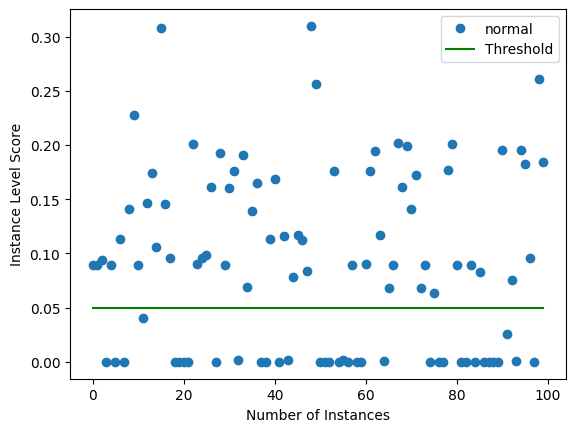

In [ ]:
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np

manual_threshold = 0.05 # remove for outlier_detector.threshold
selected_threshold = manual_threshold
# selected_threshold = outlier_detector.threshold

plot_instance_score(results, np.zeros(X_small_test.shape[0],).astype(int), ["normal", "outlier"], selected_threshold)
outlier_indices = np.where(results['data']["instance_score"] > selected_threshold)[0]
inlier_indices = np.where(results['data']["instance_score"] <= selected_threshold)[0]

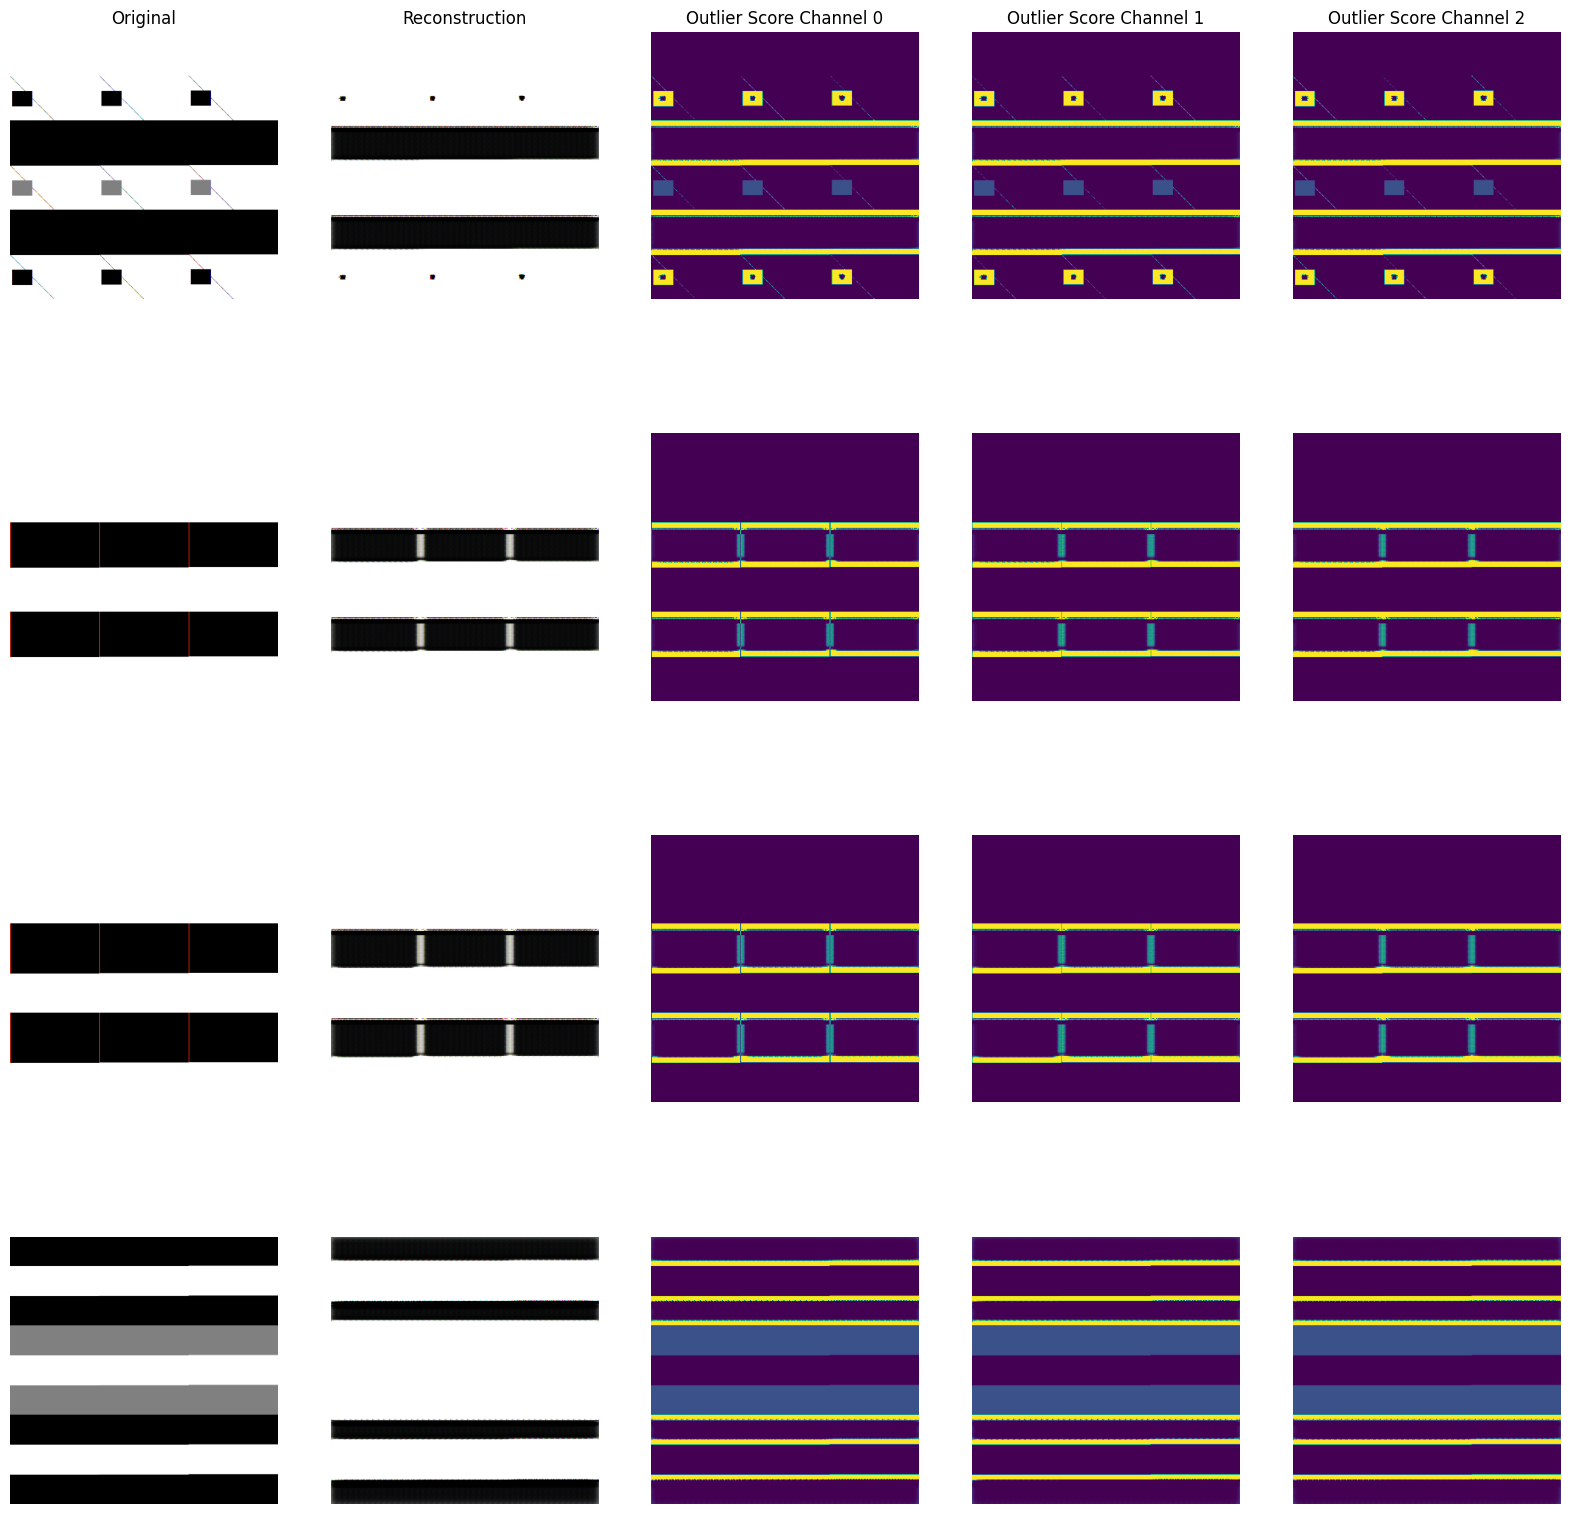

In [ ]:
X_recon = outlier_detector.ae(tf.convert_to_tensor(X_small_test)).numpy()
outlier_samples = np.random.choice(outlier_indices, size=4)

# Plot Outliers
plot_feature_outlier_image(results,
                           X_small_test,
                           X_recon=X_recon,
                           instance_ids=outlier_samples,  # pass a list with indices of instances to display
                           n_channels=3,
                           outliers_only=False)  # only show outlier predictions

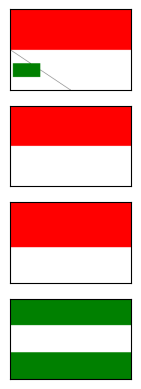

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_outlier_photos = [test_set.images[idx] for idx in np.array(row_ids)[outlier_samples]]

imgs = [mpimg.imread(sample_outlier_photos[i]) for i in range(4)]
fig, axs = plt.subplots(4, 1)

for i in range(4):
  axs[i].imshow(imgs[i])
  axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.show()

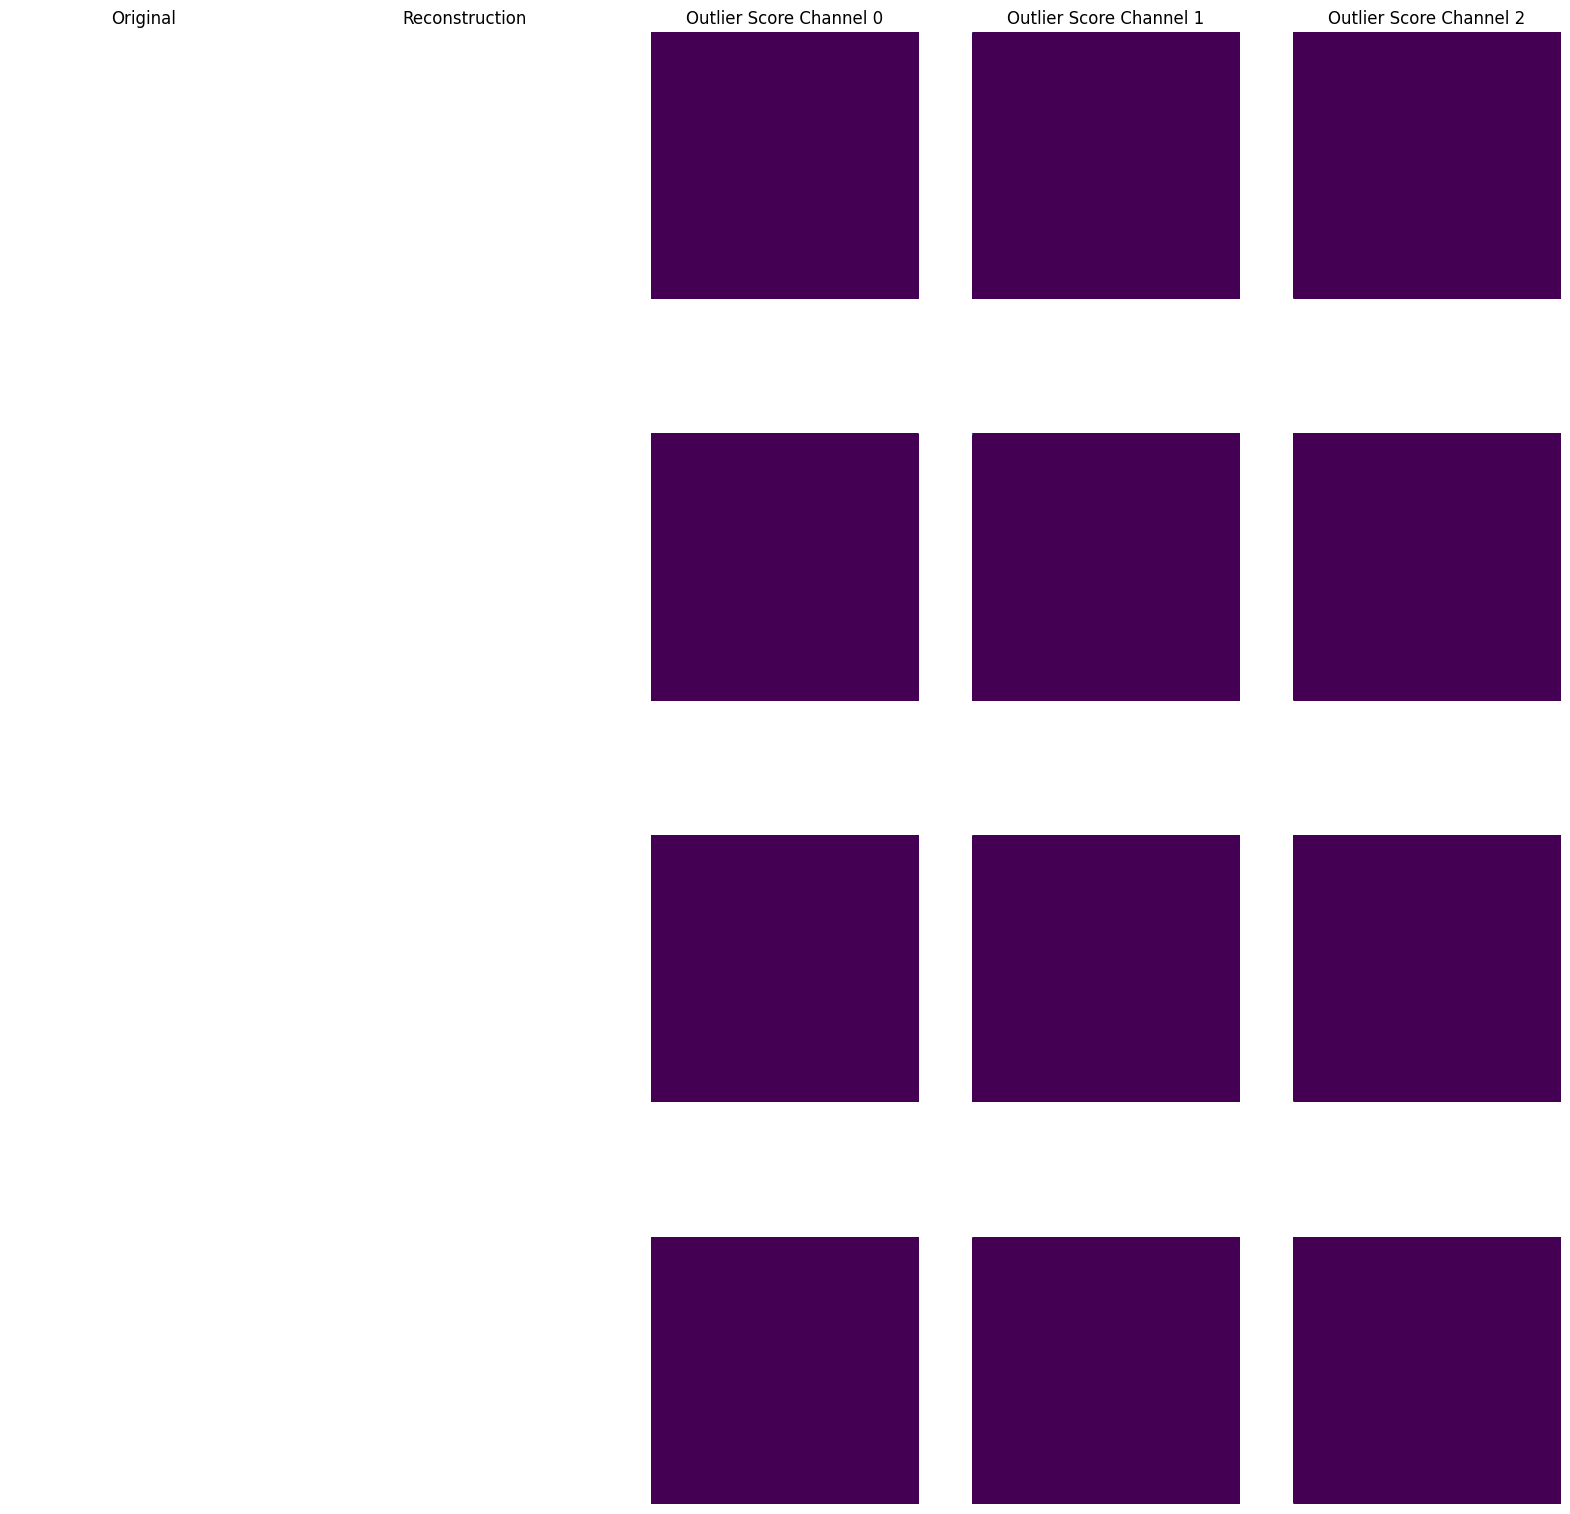

In [ ]:
# Plot inliers
inlier_samples = np.random.choice(inlier_indices, size=4)

plot_feature_outlier_image(results,
                           X_small_test,
                           X_recon=X_recon,
                           instance_ids=inlier_samples,  # pass a list with indices of instances to display
                           n_channels=3,
                           outliers_only=False)  # only show outlier predictions

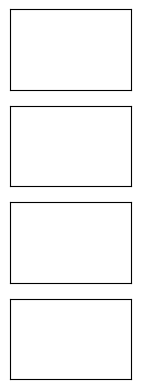

In [ ]:
sample_inlier_photos = [test_set.images[idx] for idx in np.array(row_ids)[inlier_samples]]

imgs = [mpimg.imread(sample_inlier_photos[i]) for i in range(4)]
fig, axs = plt.subplots(4, 1)

for i in range(4):
  axs[i].imshow(imgs[i])
  axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.show()

In [ ]:
outlier_photos = [train_set.images[idx] for idx in outlier_indices]
inlier_photos = [train_set.images[idx] for idx in inlier_indices]

In [ ]:
SAVE_PHOTO_STUFF = False

In [ ]:
import json

if SAVE_PHOTO_STUFF:
  outlier_save_name = f"ae_{manual_threshold}_outliers"
  inlier_save_name = f"ae_{manual_threshold}_inliers"

  outlier_save_path = os.path.join(PROJECT_BASE_PATH, outlier_save_name + ".json")
  inlier_save_path = os.path.join(PROJECT_BASE_PATH, inlier_save_name + ".json")

  with open(outlier_save_path, 'w') as outlier_out_fp:
      json.dump(outlier_photos, outlier_out_fp, indent=4)

  with open(inlier_save_path, 'w') as inlier_out_fp:
      json.dump(inlier_photos, inlier_out_fp, indent=4)